In [1]:
import pandas as pd
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from src.validation import *

In [2]:
df = pd.read_csv(r"C:\Users\ruben\OneDrive\Desktop\Linear Regression\data\Student_Performance.csv")
df.columns = df.columns.str.lower()
df.head()

,hours studied,previous scores,extracurricular activities,sleep hours,sample question papers practiced,performance index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [3]:
df.isna().sum()

hours studied                       0
previous scores                     0
extracurricular activities          0
sleep hours                         0
sample question papers practiced    0
performance index                   0
dtype: int64

In [4]:
df["extracurricular activities"] = df["extracurricular activities"].map({"Yes": 1, "No": 0})

In [5]:
X = df.drop('performance index', axis=1)
y = df['performance index']

for col in X.columns:
    print(col, abs(pd.concat([X[col], y], axis=1).corr().iloc[0,1]))

hours studied 0.37373035069872307
previous scores 0.9151891412264554
extracurricular activities 0.024524946967550563
sleep hours 0.04810583543435246
sample question papers practiced 0.04326832665907999


In [6]:
interactions = {}
X = df.drop('performance index', axis=1)
y = df['performance index']

for (col1, col2) in combinations(X.columns, 2):
    interaction = X[col1] * X[col2]
    correlation = abs(pd.concat([interaction, y], axis=1).corr().iloc[0,1])
    interactions[f"{col1} * {col2}"] = correlation

filtered_interactions = {k: v for k, v in interactions.items() if v > 0.5}
filtered_interactions

{'hours studied * previous scores': 0.7198843759172804,
 'previous scores * sleep hours': 0.65598918669855}

In [33]:
X["int_1"] = X["hours studied"] * X["previous scores"]
X["int_2"] = X["previous scores"] * X["sleep hours"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train)

y_pred = regressor.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Mean Squared Error: 4.082628398521842
Root Mean Squared Error: 2.0205515085050028
R-squared: 0.9889832909573145


In [8]:
pd.options.display.float_format = '{:.4f}'.format

intercept_reg = regressor.intercept_
coefficients_reg = regressor.coef_

coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": coefficients_reg
})

X_with_const = add_constant(X)
vif_values = [variance_inflation_factor(X_with_const.values, i + 1) for i in range(len(X.columns))]
coefficients["VIF"] = vif_values

coefficients

,Feature,Coefficient,VIF
0,hours studied,7.4013,1.0005
1,previous scores,17.6373,1.0003
2,extracurricular activities,0.3043,1.0008
3,sleep hours,0.8100,1.0006
4,sample question papers practiced,0.5488,1.0006


In [9]:
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)
X_test_scaled_df.index = X_test.index

record = X_test_scaled_df.iloc[21]

y_pred = regressor.predict(record.values.reshape(1, -1))

true_index = record.name
true_value = y_test.loc[true_index]

print(f"Predicted value: {y_pred[0]:,.2f}".replace(","," "))
print(f"True value: {true_value:.2f}")

Predicted value: 15.43
True value: 15.00


In [10]:
record = X_test_scaled_df.iloc[21]
predicted_value = intercept_reg + (record * coefficients.set_index("Feature")["Coefficient"]).sum()

for coefficient, value in zip(coefficients.set_index("Feature")["Coefficient"], record):
    print(f"{coefficient:.4f} * {value:.4f}")

print(f"\nPredicted Value: {predicted_value:.2f}")

7.4013 * -1.5351
17.6373 * -1.6451
0.3043 * 1.0108
0.8100 * 0.8587
0.5488 * -0.9145

Predicted Value: 15.43


In [11]:
formula = f"y = {intercept_reg:.2f}"

for feature, coef in zip(coefficients["Feature"], coefficients["Coefficient"]):
    formula += f" + ({coef}) * {feature}"

print("Regression Formula:")
print(formula)

Regression Formula:
y = 55.31 + (7.401340794046578) * hours studied + (17.63727126717767) * previous scores + (0.30429075596393007) * extracurricular activities + (0.8100310701229869) * sleep hours + (0.5488417139901998) * sample question papers practiced


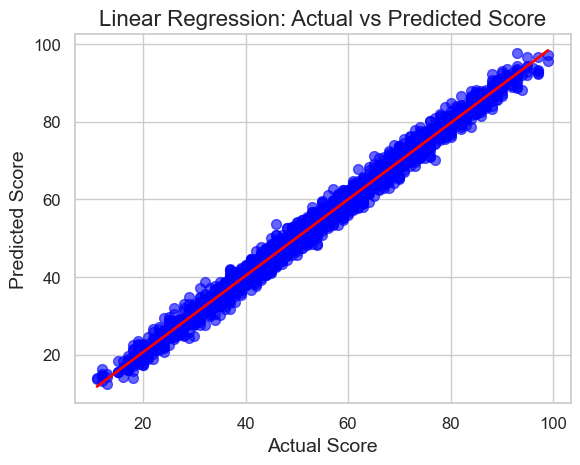

In [14]:
sns.set(style="whitegrid")

sns.regplot(x=y_test, y=y_pred, line_kws={'color': 'red', 'linewidth': 2}, ci=None, scatter_kws={'color': 'blue', 'alpha': 0.6, 's': 50})

plt.xlabel("Actual Score", fontsize=14)
plt.ylabel("Predicted Score", fontsize=14)
plt.title("Linear Regression: Actual vs Predicted Score", fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

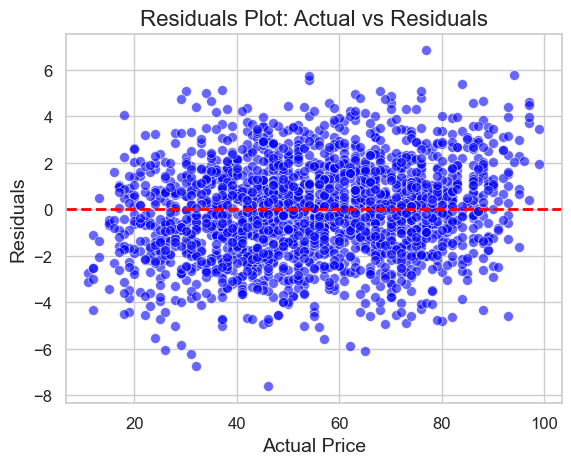

In [15]:
sns.set(style="whitegrid")

residuals = y_test - y_pred
sns.scatterplot(x=y_test, y=residuals, color='blue', alpha=0.6, s=50)

plt.xlabel("Actual Price", fontsize=14)
plt.ylabel("Residuals", fontsize=14)
plt.title("Residuals Plot: Actual vs Residuals", fontsize=16)

plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.grid(True)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

Residuals are normally distributed


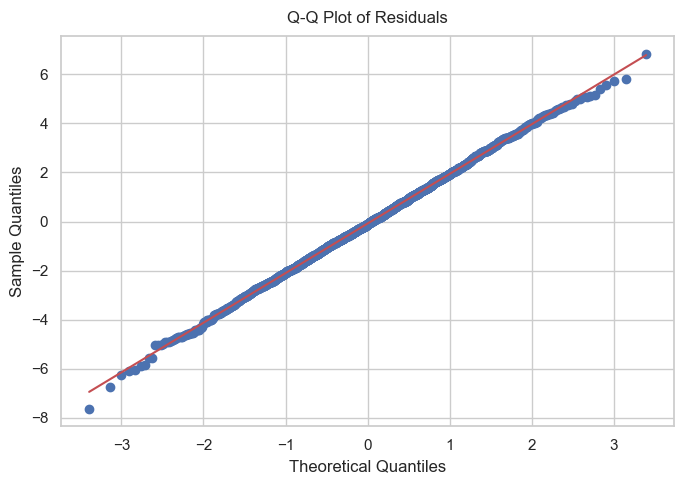

In [16]:
residuals = y_test - y_pred

check_residuals(residuals)
qqplot(residuals)

Mean of Residuals: -0.0798
Standard Deviation of Residuals: 2.0190

Checking for Normality:
p-value: 0.9751
Residuals are normally distributed.

Checking for Homoscedasticity:
p-value: 0.0000
Residuals are heteroscedastic.


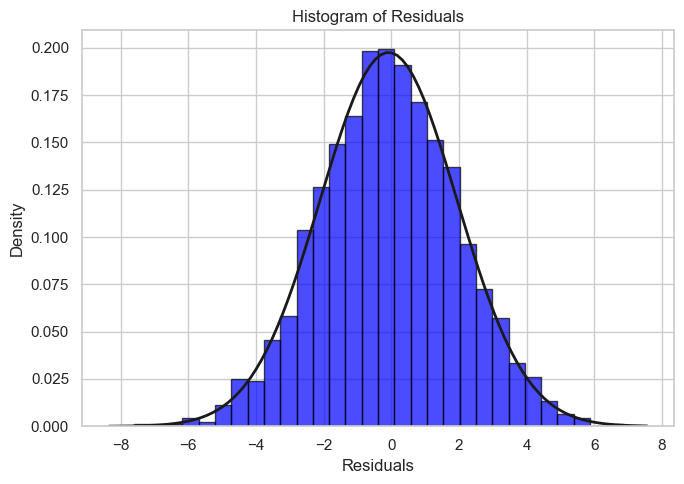

In [21]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(7, 5))

ax.hist(residuals, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
ax.set_title("Histogram of Residuals")

xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(residuals), np.std(residuals))
ax.plot(x, p, 'k', linewidth=2)
ax.set_xlabel("Residuals")
ax.set_ylabel("Density")

plt.tight_layout()
plt.show()